(436, 14)
           Symbol Series  Prev Close    Open   High     Low    Last   Close  \
Date                                                                          
2019-01-01   INFY     EQ      658.95  660.95  666.3  654.15  665.95  665.05   
2019-01-02   INFY     EQ      665.05  666.00  674.0  662.05  668.00  669.05   
2019-01-03   INFY     EQ      669.05  672.00  677.0  663.10  668.00  669.15   
2019-01-04   INFY     EQ      669.15  671.75  673.9  651.00  660.25  661.05   
2019-01-07   INFY     EQ      661.05  665.00  673.6  661.50  671.70  671.70   

              VWAP   Volume      Turnover  Trades  Deliverable Volume  \
Date                                                                    
2019-01-01  660.66  2943390  1.944579e+14   45422             1282161   
2019-01-02  669.97  7416655  4.968963e+14  108094             3880800   
2019-01-03  669.66  6827249  4.571929e+14  125781             3676359   
2019-01-04  660.17  7889310  5.208305e+14  187590             3747741  

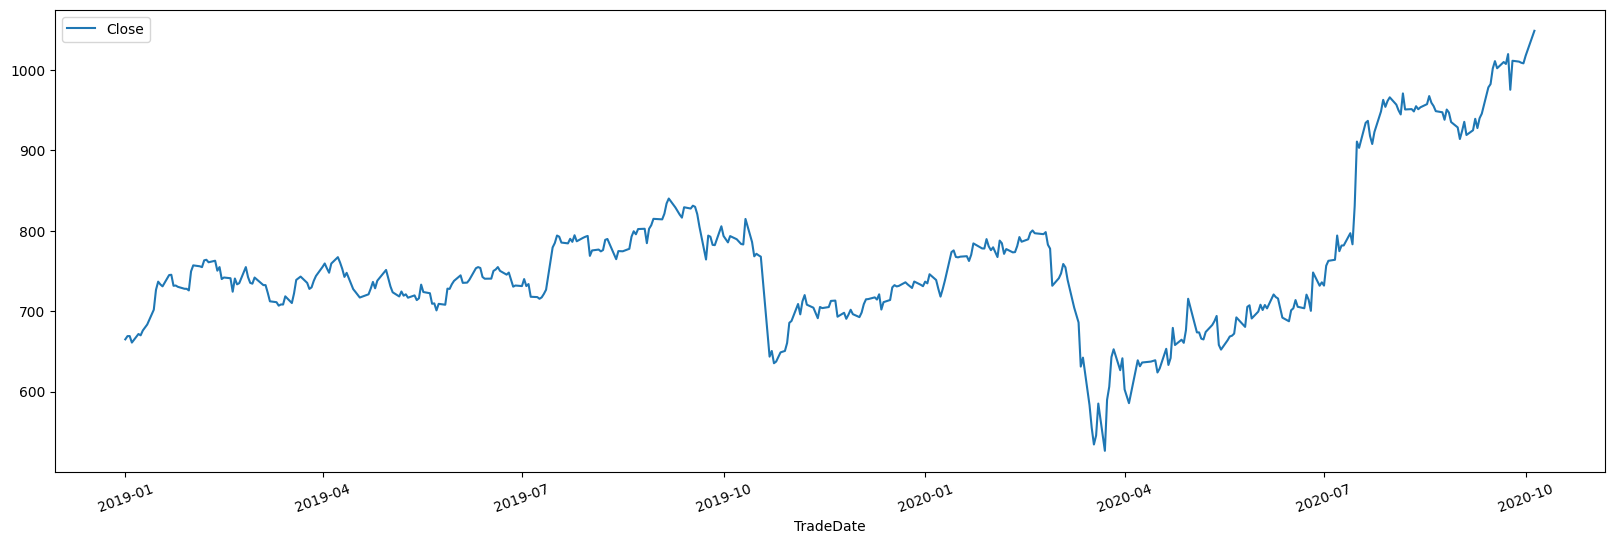

[[665.05]
 [669.05]
 [669.15]
 [661.05]
 [671.7 ]]
### After Normalization ###

#### Input Data shape ####
(426, 10, 1)

#### Output Data shape ####
(426, 1)

#### Training Data shape ####
(421, 10, 1)
(421, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)
[[0.26539014]
 [0.27304931]
 [0.27324079]
 [0.25773097]
 [0.2781235 ]
 [0.2749641 ]
 [0.28654859]
 [0.29344184]
 [0.30071805]
 [0.33595022]] -- [0.38324557]
[[0.27304931]
 [0.27324079]
 [0.25773097]
 [0.2781235 ]
 [0.2749641 ]
 [0.28654859]
 [0.29344184]
 [0.30071805]
 [0.33595022]
 [0.38324557]] -- [0.40277645]
Number of TimeSteps: 10
Number of Features: 1
Epoch 1/100
85/85 [==============================] - 4s 8ms/step - loss: 0.1578
Epoch 2/100
85/85 [==============================] - 1s 7ms/step - loss: 0.0072
Epoch 3/100
85/85 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 4/100
85/85 [==============================] - 4s 42ms/step - loss: 0.0062
Epoch 5/100
85/85 [==============================] - 4s 45ms

KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import array
import time

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)


# Getting Stock data using nsepy library
from nsepy import get_history
from datetime import datetime

startDate = datetime(2019, 1, 1)
endDate = datetime(2020, 10, 5)

# Fetching the data
StockData = get_history(symbol='INFY', start=startDate, end=endDate)
print(StockData.shape)
print(StockData.head())

# Creating a column as date
StockData['TradeDate'] = StockData.index


StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20, 6), rot=20)
plt.show()

# Extracting the closing prices of each day
FullData = StockData[['Close']].values
print(FullData[0:5])

# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or normalization
# sc = StandardScaler()
sc = MinMaxScaler()

DataScaler = sc.fit(FullData)
X = DataScaler.transform(FullData)
# X=FullData

print('### After Normalization ###')
X[0:5]

# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps = 10  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps, NumerOfRows, 1):
    x_sample = X[i - TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data = np.array(X_samples)
X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data = np.array(y_samples)
y_data = y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)

# Choosing the number of testing data records
TestingRecords = 5

# Splitting the data into train and test
X_train = X_data[:-TestingRecords]
X_test = X_data[-TestingRecords:]
y_train = y_data[:-TestingRecords]
y_test = y_data[-TestingRecords:]

############################################

# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)



# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units=10, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units=5, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units=5, activation='relu', return_sequences=False))

# Adding the output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')



# Measuring the time taken by the model to train
StartTime = time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size=5, epochs=100)

EndTime = time.time()
print("## Total Time Taken: ", round((EndTime - StartTime) / 60), 'Minutes ##')

# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig = y_test
orig = DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100 * (abs(orig - predicted_Price) / orig)).mean())

# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color='blue', label='Predicted Volume')
plt.plot(orig, color='lightblue', label='Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

# Generating predictions on full data
TrainPredictions = DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions = DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions = np.append(TrainPredictions, TestPredictions)
FullDataOrig = FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color='blue', label='Predicted Price')
plt.plot(FullDataOrig, color='lightblue', label='Original Price')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

# Last 10 days prices
Last10Days = np.array([1002.15, 1009.9, 1007.5, 1019.75, 975.4,
                       1011.45, 1010.4, 1009, 1008.25, 1017.65])

# Normalizing the data just like we did for training the model
Last10Days = DataScaler.transform(Last10Days.reshape(-1, 1))

# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples = 1
TimeSteps = 10
NumFeatures = 1
Last10Days = Last10Days.reshape(NumSamples, TimeSteps, NumFeatures)

#############################

# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print(predicted_Price)

# Considering the Full Data again which we extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])

print('###################')

# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X = X.reshape(X.shape[0], )
print('Scaled Prices')
print(X[-10:])

# Multi step data preparation

# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps = 10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps = 5  # How many days in future you want to predict the prices

# Iterate thru the values to create combinations
for i in range(TimeSteps, NumerOfRows - FutureTimeSteps, 1):
    x_sample = X[i - TimeSteps:i]
    y_sample = X[i:i + FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

################################################

# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data = np.array(X_samples)
X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
print('### Input Data Shape ###')
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data = np.array(y_samples)
print('### Output Data Shape ###')
print(y_data.shape)

# Choosing the number of testing data records
TestingRecords = 5

# Splitting the data into train and test
X_train = X_data[:-TestingRecords]
X_test = X_data[-TestingRecords:]
y_train = y_data[:-TestingRecords]
y_test = y_data[-TestingRecords:]

#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)

print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)

# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units=10, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units=5, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units=5, activation='relu', return_sequences=False))

# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps
# Based on the number of future days we want to predict
regressor.add(Dense(units=FutureTimeSteps))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

###################################################################

import time

# Measuring the time taken by the model to train
StartTime = time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size=5, epochs=100)

EndTime = time.time()
print("############### Total Time Taken: ", round((EndTime - StartTime) / 60), 'Minutes #############')

# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)

# Getting the original price values for testing data
orig = y_test
orig = DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)


for i in range(len(orig)):
    Prediction = predicted_Price[i]
    Original = orig[i]

    # Visualising the results
    plt.plot(Prediction, color='blue', label='Predicted Volume')
    plt.plot(Original, color='lightblue', label='Original Volume')

    plt.title('### Accuracy of the predictions:' + str(
        100 - (100 * (abs(Original - Prediction) / Original)).mean().round(2)) + '% ###')
    plt.xlabel('Trading Date')

    startDateIndex = (FutureTimeSteps * TestingRecords) - FutureTimeSteps * (i + 1)
    endDateIndex = (FutureTimeSteps * TestingRecords) - FutureTimeSteps * (i + 1) + FutureTimeSteps
    TotalRows = StockData.shape[0]

    plt.xticks(range(FutureTimeSteps),
               StockData.iloc[TotalRows - endDateIndex: TotalRows - (startDateIndex), :]['TradeDate'])
    plt.ylabel('Stock Price')

    plt.legend()
    fig = plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

# Making predictions on test data - the test data needs to be hte last 10 days printed on the 
#original prices array
Last10DaysPrices = array([1376.2, 1371.75, 1387.15, 1370.5, 1344.95,
                          1312.05, 1316.65, 1339.45, 1339.7, 1340.85])

# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices = Last10DaysPrices.reshape(-1, 1)

# Scaling the data on the same level on which model was trained
X_test = DataScaler.transform(Last10DaysPrices)

NumberofSamples = 1
TimeSteps = X_test.shape[0]
NumberofFeatures = X_test.shape[1]
# Reshaping the data as 3D input
X_test = X_test.reshape(NumberofSamples, TimeSteps, NumberofFeatures)

# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)

# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
print(Next5DaysPrice)